In [1]:
## loading libraries
library(repr)
library(tidyverse)
library(tidymodels)
library(RCurl)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
## read data on .csv file from GitHub 
url <- getURL("https://raw.githubusercontent.com/nitahieb/dsci100project/master/atp2017-2019.csv")
tennis_data_raw <- read_csv(url)

Warning message:
“Missing column names filled in: 'X1' [1]”


In [3]:
## cleaning and wrangling data
tennis_data <- tennis_data_raw %>%
    select(-X1) %>%
    mutate(rank_diff = (winner_rank - loser_rank), age_diff = (winner_age - loser_age)) %>%
    mutate(higher_rank_win = (winner_rank > loser_rank)) %>%
    select(rank_diff, age_diff, higher_rank_win)

In [4]:
## setting seed to keep data random
set.seed(9999)

#splitting the original data set into a training and testing data set. 
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = higher_rank_win, na.rm=TRUE)
tennis_train_temp <- training(tennis_split)
tennis_test <- testing(tennis_split)

#removing any NA logicals from training data
tennis_train <- na.omit(tennis_train_temp)

In [5]:
## exploratory data analysis
tennis_train

## rank_diff represents the ranking difference between the winner and the loser of the tennis
## match.

## age_diff represents the age difference between the winner and loser of the tennis match.

## our chosen predictor variable is higher_rank_win which represents a logical about if the
## higher ranked player was able to defeat the lower ranked player in the tennis match. 

## through the use of na.rm=TRUE, we are able to begin our analyses with rows that are not 
## missing data.

rank_diff,age_diff,higher_rank_win
<dbl>,<dbl>,<lgl>
-223,-10.819986,FALSE
208,13.837098,TRUE
-2,-5.125257,FALSE
⋮,⋮,⋮
-2,-0.4380561,FALSE
-11,3.2142368,FALSE
-61,-1.0951403,FALSE


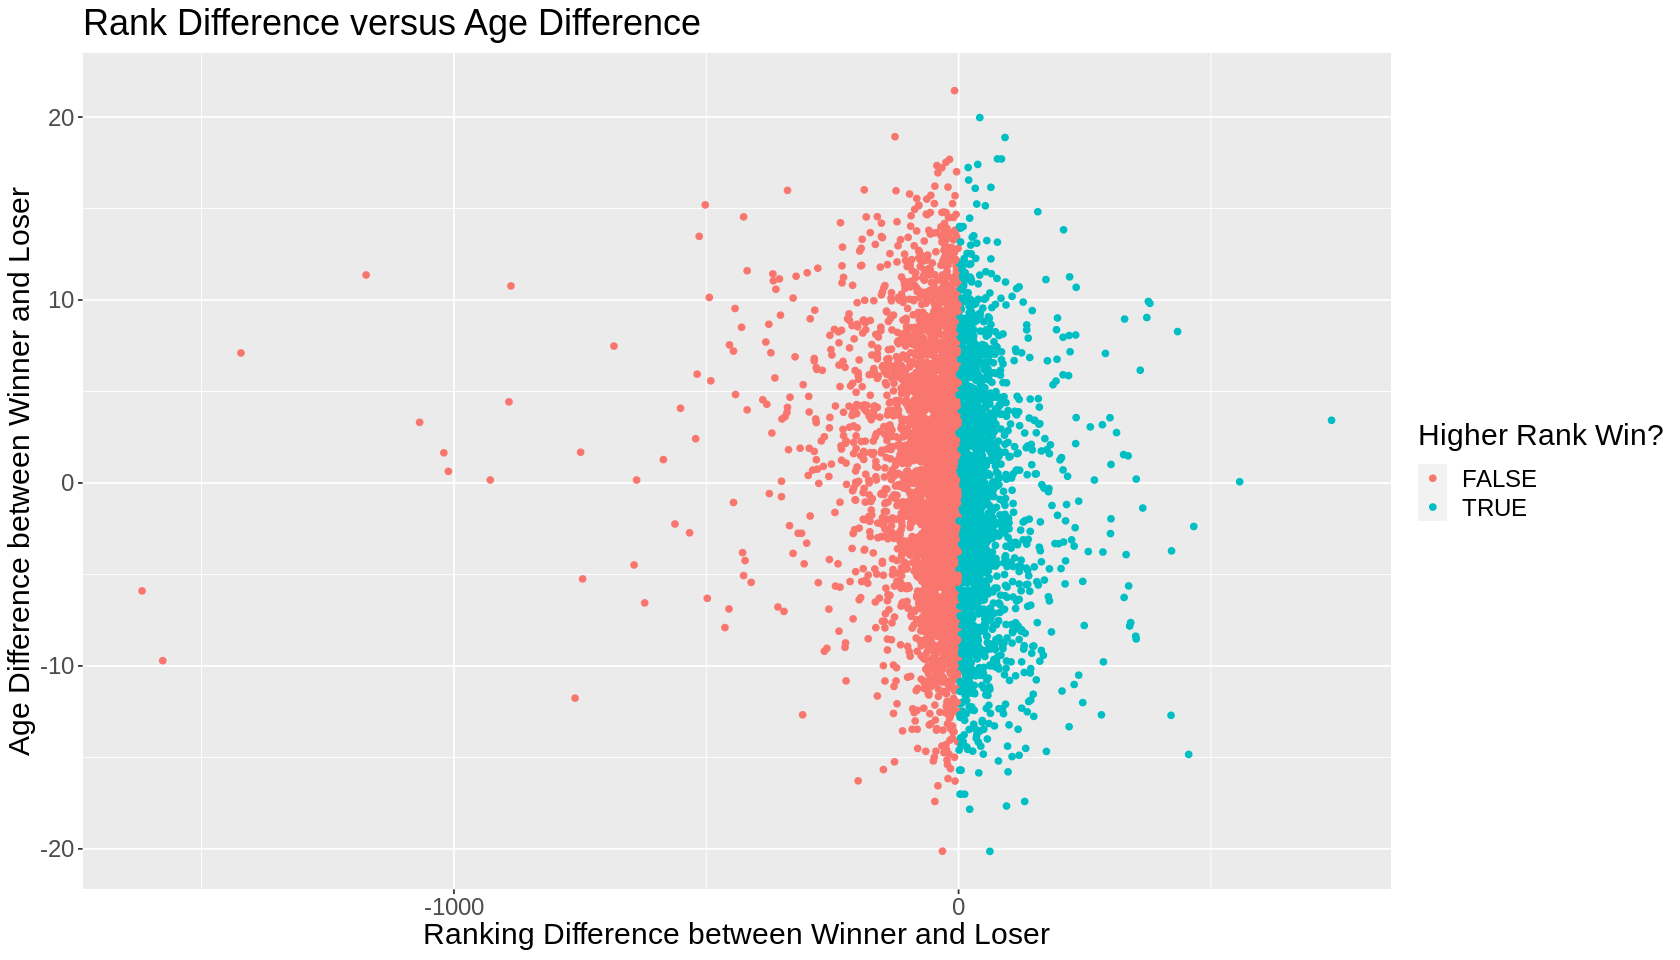

In [10]:
## plotting of the data

tennis_train_plot <- tennis_train %>%
                     ggplot(aes(x = rank_diff, y = age_diff, color = higher_rank_win)) +
                     geom_point() +
                     labs(x = "Ranking Difference between Winner and Loser", y = "Age Difference between Winner and Loser", color = "Higher Rank Win?") +
                     ggtitle("Rank Difference versus Age Difference") +
                     theme(text = element_text (size = 18))
tennis_train_plot